# Objective

Demonstrate how self training can be used to supplement ML classification accuracy when a majority of the data available are unlabeled.

25% of data set aside as test set

1% of data kept as labeled train set

74% of data designated as 'unlabeled' - labels removed


# Imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

# Obtain Data

In [78]:
# Load data

df = pd.read_csv('surgical_deepnet.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14635 entries, 0 to 14634
Data columns (total 25 columns):
bmi                    14635 non-null float64
Age                    14635 non-null float64
asa_status             14635 non-null int64
baseline_cancer        14635 non-null int64
baseline_charlson      14635 non-null int64
baseline_cvd           14635 non-null int64
baseline_dementia      14635 non-null int64
baseline_diabetes      14635 non-null int64
baseline_digestive     14635 non-null int64
baseline_osteoart      14635 non-null int64
baseline_psych         14635 non-null int64
baseline_pulmonary     14635 non-null int64
ahrq_ccs               14635 non-null int64
ccsComplicationRate    14635 non-null float64
ccsMort30Rate          14635 non-null float64
complication_rsi       14635 non-null float64
dow                    14635 non-null int64
gender                 14635 non-null int64
hour                   14635 non-null float64
month                  14635 non-null int64

# Scrub Data

In [23]:
# Shuffle the data

df = df.sample(frac=1, random_state=15).reset_index(drop=True)

# Generate indices for splits

test_ind = round(len(df)*0.25)
train_ind = test_ind + round(len(df)*0.01)
unlabeled_ind = train_ind + round(len(df)*0.74)

# Partition the data

test = df.iloc[:test_ind]
train = df.iloc[test_ind:train_ind]
unlabeled = df.iloc[train_ind:unlabeled_ind]

# Assign data to train, test, and unlabeled sets

X_train = train.drop('complication', axis=1)
y_train = train.complication

X_unlabeled = unlabeled.drop('complication', axis=1)

X_test = test.drop('complication', axis=1)
y_test = test.complication

In [77]:
# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (897, 24)
y_train dimensions: (897,)

X_test dimensions: (3659, 24)
y_test dimensions: (3659,)

X_unlabeled dimensions: (10079, 24)


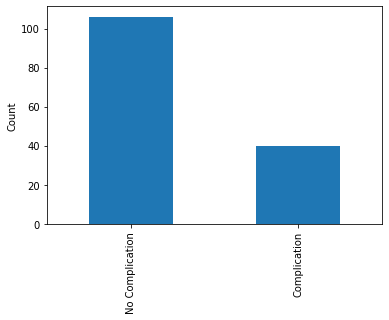

In [30]:
# Visualize class distribution

y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Complication', 'Complication'])
plt.ylabel('Count');

# Initial Model

In [31]:
# Logistic Regression Classifier

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

In [32]:
train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

Train f1 Score: 0.5846153846153846
Test f1 Score: 0.5002908667830134


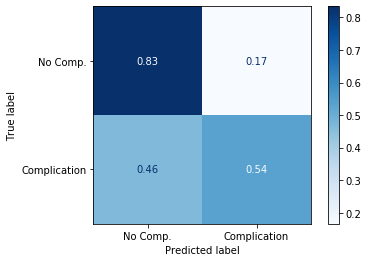

In [68]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Comp.', 'Complication']);

In [81]:
# Generate probabilities for each prediction

clf.predict_proba(X_test)

array([[0.97009391, 0.02990609],
       [0.08165935, 0.91834065],
       [0.97009391, 0.02990609],
       ...,
       [0.52087344, 0.47912656],
       [0.34980104, 0.65019896],
       [0.21382606, 0.78617394]])

# Self training procedure using Logistic Regression Classifier

In [34]:
iterations = 0

train_f1s = []
test_f1s = []
pseudo_labels = []

high_prob = [1] 
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)


    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
        
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.")
          
    iterations += 1
          
    print("\n")

Iteration 0
Train f1: 0.5846153846153846
Test f1: 0.5002908667830134
Now predicting labels for unlabeled data...
42 high-probability predictions added to training data.
10788 unlabeled instances remaining.


Iteration 1
Train f1: 0.7627118644067796
Test f1: 0.5037463976945246
Now predicting labels for unlabeled data...
30 high-probability predictions added to training data.
10758 unlabeled instances remaining.


Iteration 2
Train f1: 0.8181818181818182
Test f1: 0.505431675242996
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
10738 unlabeled instances remaining.


Iteration 3
Train f1: 0.847457627118644
Test f1: 0.5076835515082526
Now predicting labels for unlabeled data...
21 high-probability predictions added to training data.
10717 unlabeled instances remaining.


Iteration 4
Train f1: 0.8615384615384616
Test f1: 0.5096262740656852
Now predicting labels for unlabeled data...
22 high-probability predictions added to training data.
1

Iteration 40
Train f1: 0.9475587703435805
Test f1: 0.5254054054054054
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
10083 unlabeled instances remaining.


Iteration 41
Train f1: 0.9475587703435805
Test f1: 0.5272825499729876
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
10082 unlabeled instances remaining.


Iteration 42
Train f1: 0.9475587703435805
Test f1: 0.5262020529443544
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
10080 unlabeled instances remaining.


Iteration 43
Train f1: 0.947935368043088
Test f1: 0.5275675675675675
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
10079 unlabeled instances remaining.


Iteration 44
Train f1: 0.9481216457960644
Test f1: 0.5259179265658748
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.


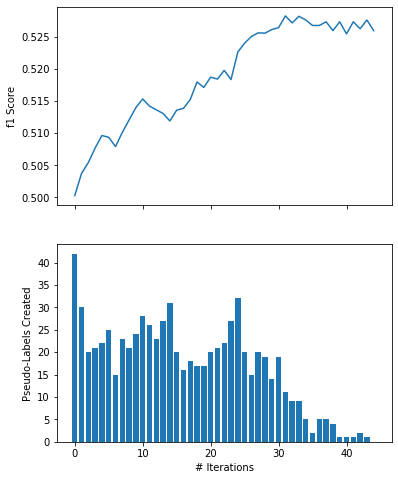

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8), sharex=True)
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

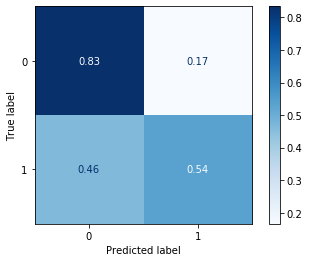

In [66]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Comp.', 'Complication']);